## Importing Libraries

In [65]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import pickle
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.decomposition import PCA


tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.4


## Disclaimer

To test the code, we used kaggle, so it is first necessary to import in kaggle the original .zip file containing the original dataset.
A second option could be using Google Drive. In order to use it is necessary to mount the drive, import the original .zip file, unzip it and move inside the directory created. The following lines of code will do this. 

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/Colab Notebooks/Challenge2

In [ ]:
!unzip training_dataset_homework2.zip

## Suppress Warnings

In [66]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Set Seeding for Reproducibility

In [27]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## Exploration Data Analysis (EDA)

### Load the dataset

In [28]:
X_train = np.load('/kaggle/input/dataset2/x_train.npy')
y_train = np.load('/kaggle/input/dataset2/y_train.npy')

print(X_train.shape)
print(y_train.shape)

(2429, 36, 6)
(2429,)


In [29]:
X_train, X_validation, y_train, y_validation= train_test_split(X_train, y_train, test_size=0.20, random_state=seed, stratify=y_train)

print(X_train.shape)
print(X_validation.shape)

(1943, 36, 6)
(486, 36, 6)


### Convert the sparse labels to categorical values

In [30]:
y_train = tfk.utils.to_categorical(y_train)
y_validation = tfk.utils.to_categorical(y_validation)

print(y_train.shape)
print(y_validation.shape)

(1943, 12)
(486, 12)


### Scaling

3 different types of scalers, flattening the first two dimensions and moving back to the original 3D shape. None of these methods of scaling helped us in having better results. When using this, remeber to substitute X_train with X_train_scaled when performing the model.fit

In [12]:
#scaler = MinMaxScaler()
# scaler = StandardScaler()
#scaler = RobustScaler()

# num_instances, num_time_steps, num_features = X_train.shape
# X_train_scaled = np.reshape(X_train, newshape=(-1, num_features))
# X_train_scaled = scaler.fit_transform(X_train_scaled)
# X_train_scaled = np.reshape(X_train_scaled, newshape=(num_instances, num_time_steps, num_features))
# print(X_train_scaled.shape)

(1943, 36, 6)


### Class Weights

Applying class weights in order to contrast the imbalanced of the times series. Class 0 is the one presenting the fewer samples. Unfortunately it didn't help in having better results for the models that we'll present.

In [15]:
# class_weights = compute_class_weight(class_weight  = 'balanced',
#                                                  classes = np.unique(y_train),
#                                                  y = y_train)
# class_weights = dict(zip(np.unique(y_train), class_weights))
# print(class_weights)

{0: 5.996913580246914, 1: 1.6522108843537415, 2: 0.7496141975308642, 3: 0.5308743169398907, 4: 3.2383333333333333, 5: 1.3271857923497268, 6: 0.6476666666666666, 7: 2.998456790123457, 8: 1.6866319444444444, 9: 0.2603161843515541, 10: 2.611559139784946, 11: 3.9491869918699187}


## Build and train models

In [31]:
input_shape = X_train.shape[1:]
classes = y_train.shape[-1]
batch_size = 64 #tried 32, 64, 128, 256
epochs = 200
print(input_shape)

(36, 6)


### Parallel CNN-LSTM (Best Model)

In [67]:
def build_parallel_cnn_lstm(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn1 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn1 = tfkl.MaxPooling1D()(cnn1)
    cnn1 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn1)
#     cnn1 = tfkl.GlobalAveragePooling1D()(cnn1)

    
    cnn2 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn2 = tfkl.MaxPooling1D()(cnn2)
    cnn2 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn2)
#     cnn2 = tfkl.GlobalAveragePooling1D()(cnn2)

    merged = tfk.layers.concatenate([cnn1, cnn2
                                    ], axis=1)

    lstm = (tfkl.LSTM(1024, return_sequences=True))(merged)
    lstm = (tfkl.LSTM(1024))(lstm)
#     lstm = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(1024, activation='relu')(lstm)
#     bn = tfkl.BatchNormalization()(classifier)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    classifier = tfkl.Dense(1024, activation='relu')(classifier)
#     bn = tfkl.BatchNormalization()(classifier)
#     noise = tfkl.GaussianNoise(.1)(classifier)
    dropout = tfkl.Dropout(.4, seed=seed)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 36, 512)      9728        Input[0][0]                      
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 36, 512)      9728        Input[0][0]                      
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 36, 1024)     1573888     conv1d_16[0][0]                  
______________________________________________________________________________________________

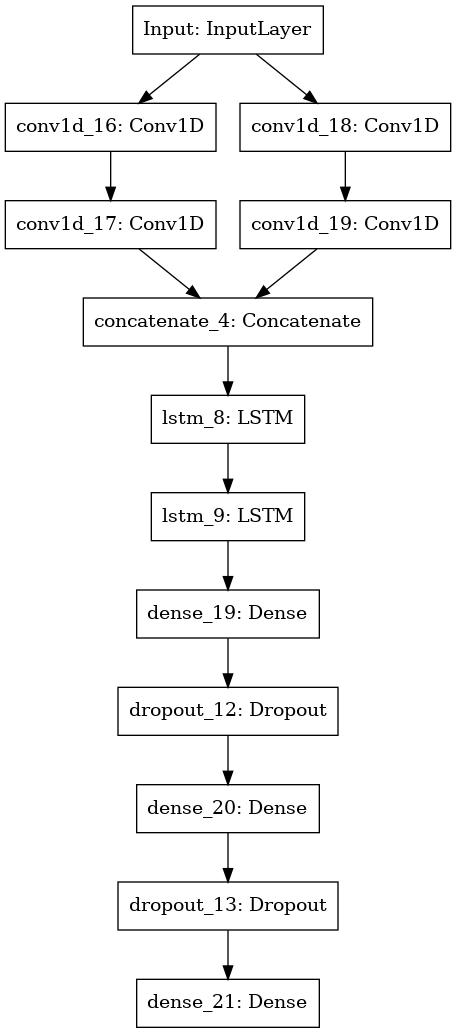

In [68]:
model = build_parallel_cnn_lstm(input_shape, classes)
model.summary()
tfk.utils.plot_model(model)

In [35]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_validation, y_validation),
#     class_weight = class_weights,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
31/31 [==============================] - 6s 135ms/step - loss: 1.5627 - accuracy: 0.4545 - val_loss: 1.3077 - val_accuracy: 0.5123
Epoch 2/200
31/31 [==============================] - 3s 110ms/step - loss: 1.2909 - accuracy: 0.5533 - val_loss: 1.1854 - val_accuracy: 0.5741
Epoch 3/200
31/31 [==============================] - 3s 111ms/step - loss: 1.1319 - accuracy: 0.6207 - val_loss: 1.0714 - val_accuracy: 0.6235
Epoch 4/200
31/31 [==============================] - 4s 113ms/step - loss: 1.0444 - accuracy: 0.6366 - val_loss: 1.0596 - val_accuracy: 0.6235
Epoch 5/200
31/31 [==============================] - 3s 111ms/step - loss: 1.0152 - accuracy: 0.6526 - val_loss: 1.0488 - val_accuracy: 0.6481
Epoch 6/200
31/31 [==============================] - 3s 110ms/step - loss: 0.9082 - accuracy: 0.6855 - val_loss: 1.0250 - val_accuracy: 0.6605
Epoch 7/200
31/31 [==============================] - 3s 111ms/step - loss: 0.8641 - accuracy: 0.7066 - val_loss: 1.0329 - val_accuracy: 0.6646

#### Plotting graphs

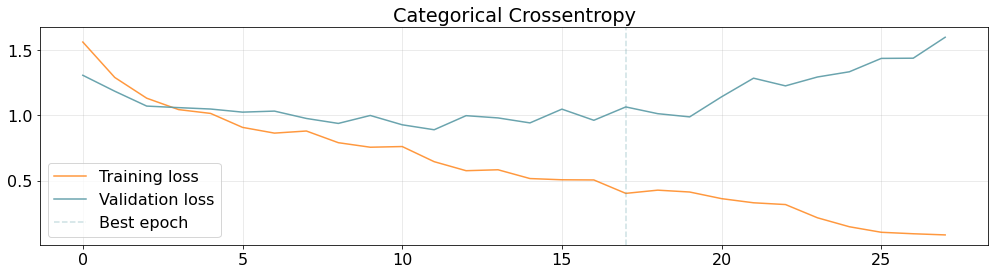

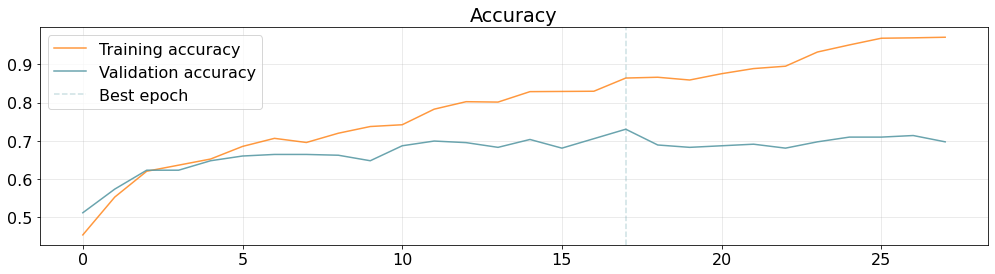

In [37]:
best_epoch = np.argmax(history['val_accuracy'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Categorical Crossentropy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

#### Predictions and Confusion Matrix

In [38]:
# Predict the val set with the LSTM
predictions = model.predict(X_validation)
predictions.shape

(486, 12)

In [42]:
# Map activities to integers
label_mapping = {
    'Class0': 0,
    'Class1': 1,
    'Class2': 2,
    'Class3': 3,
    'Class4': 4,
    'Class5': 5
}

Accuracy: 0.7305
Precision: 0.7416
Recall: 0.6038
F1: 0.6392


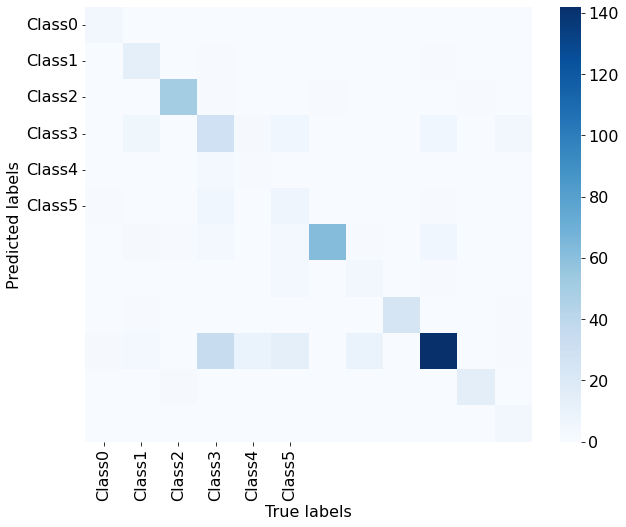

In [43]:
# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_validation, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_validation, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_validation, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_validation, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_validation, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, cmap='Blues', xticklabels=list(label_mapping.keys()), yticklabels=list(label_mapping.keys()))
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

#### Save Model

In [ ]:
model.save('/kaggle/working/parallel_cnn_lstm')
!zip -r parallel_cnn_lstm.zip '/kaggle/working/parallel_cnn_lstm' 

### Models from Laboratory Section

#### LSTM

In [ ]:
# def build_LSTM_classifier(input_shape, classes):
#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     # Feature extractor
#     lstm = tfkl.LSTM(512, return_sequences=True)(input_layer)
#     lstm = tfkl.LSTM(512)(lstm)
#     dropout = tfkl.Dropout(.5, seed=seed)(lstm)

#     # Classifier
#     classifier = tfkl.Dense(512, activation='relu')(dropout)
#     output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

#     # Return the model
#     return model
    
    
# model = build_LSTM_classifier(input_shape, classes)
# model.summary()

In [ ]:
# # Train the model
# history = model.fit(
#     x = X_train,
#     y = y_train,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_split=.2,
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
#         tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
#     ]
# ).history

#### biLSTM

In [ ]:
# def build_BiLSTM_classifier(input_shape, classes):
#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     # Feature extractor
#     bilstm = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(input_layer)
#     bilstm = tfkl.Bidirectional(tfkl.LSTM(128))(bilstm)
#     dropout = tfkl.Dropout(.5, seed=seed)(bilstm)

#     # Classifier
#     classifier = tfkl.Dense(128, activation='relu')(dropout)
#     output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

#     # Return the model
#     return model
    
# model = build_BiLSTM_classifier(input_shape, classes)
# model.summary()

In [ ]:
# # Train the model
# history = model.fit(
#     x = X_train,
#     y = y_train,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_split=.1,
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
#         tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
#     ]
# ).history

#### CNN

In [ ]:
# def build_1DCNN_classifier(input_shape, classes):
#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     # Feature extractor
    
#     cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
#     cnn = tfkl.MaxPooling1D()(cnn)
#     cnn = tfkl.Conv1D(256,3,padding='same',activation='relu')(cnn)
#     cnn = tfkl.MaxPooling1D()(cnn)
#     cnn = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn)
#     gap = tfkl.GlobalAveragePooling1D()(cnn)
#     dropout = tfkl.Dropout(.3, seed=seed)(gap)

#     # Classifier
#     classifier = tfkl.Dense(512, activation='relu')(dropout)
#     output_layer = tfkl.Dense(classes, activation='softmax')(classifier)

#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

#     # Return the model
#     return model
    
# model = build_1DCNN_classifier(input_shape, classes)
# model.summary()

In [ ]:
# # Train the model
# history = model.fit(
#     x = X_train,
#     y = y_train,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_split=.1,
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
#         tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
#     ]
# ).history

#### GRU

In [59]:
# def build_GRU_classifier(input_shape, classes):
#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     # Feature extractor
#     cnn = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128))(input_layer)
#     cnn = tf.keras.layers.Dense(256, activation='relu')(cnn)
#     cnn = tfkl.Dropout(0.5, seed=seed)(cnn)
#     output_layer = tf.keras.layers.Dense(classes, activation='softmax')(cnn)
    
#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

#     # Return the model
#     return model
    
    
    
# model = build_GRU_classifier(input_shape, classes)
# model.summary()

In [ ]:
# history = model.fit(
#     x = X_train,
#     y = y_train,
#     batch_size = batch_size,
#     epochs = epochs,
#     validation_split=.1,
#     callbacks = [
#         tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True),
#         #tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=10, factor=0.5, min_lr=1e-5)
#     ]
# ).history

### Parallel Architecture

Here we present the model with two parallel branches, with a Conv1d and LSTM per each branch

In [60]:
def build_parallel(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    cnn1 = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn1 = tfkl.MaxPooling1D()(cnn1)

    cnn1 = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn1)
    cnn1 = tfkl.MaxPooling1D()(cnn1)
    
    cnn1 = tfkl.LSTM(512)(cnn1)
#     cnn1 = tfkl.GlobalAveragePooling1D()(cnn1)
    

    cnn2 = tfkl.Conv1D(256,3,padding='same',activation='relu')(input_layer)
    cnn2 = tfkl.MaxPooling1D()(cnn2)
    
    cnn2 = tfkl.Conv1D(512,3,padding='same',activation='relu')(cnn2)
    cnn2 = tfkl.MaxPooling1D()(cnn2)
    
    cnn2 = tfkl.LSTM(512)(cnn2)
#     cnn2 = tfkl.GlobalAveragePooling1D()(cnn2)

    
    merged = tfk.layers.concatenate([cnn1, cnn2# cnn4
                                    ], axis=1)

#     reshape = tfkl.Reshape((cnn1.shape[1], classes))(merged)

#     lstm = tfkl.LSTM(1024, return_sequences=True)(merged)
#     lstm = tfkl.LSTM(1024)(lstm)
    drop = tfkl.Dropout(.2, seed=seed)(merged)

    # Classifier
    classifier = tfkl.Dense(1024, activation='relu')(drop)
    classifier = tfkl.Dense(1024, activation='relu')(classifier)

    dropout = tfkl.Dropout(.4, seed=seed)(classifier)
    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [61]:
model = build_parallel(input_shape, classes)
model.summary()

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_validation, y_validation),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, 36, 6)]      0                                            
__________________________________________________________________________________________________
conv1d_12 (Conv1D)              (None, 36, 256)      4864        Input[0][0]                      
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 36, 256)      4864        Input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 18, 256)      0           conv1d_12[0][0]                  
______________________________________________________________________________________________

### ResNet

In [62]:
from tensorflow.keras.applications  import ResNet50

def build_resnet(input_shape, classes):
    
   
    
    resnet = tfk.applications.ResNet50(include_top=False, input_shape=(32,32,3), weights="imagenet")
    
    resnet.trainable= False
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    resh = tfkl.Reshape((12,6,3)) (input_layer)
    resize = tfkl.Resizing(32,32,interpolation='nearest')(resh)
    
    
    x= resnet(resize, training=False)
    x=tfkl.Flatten()(x)
    x=tfkl.Dropout(0.3, seed=seed)(x)
    
    output_layer = tfkl.Dense(classes, activation='softmax')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model

In [63]:
model = build_resnet(input_shape, classes)
model.summary()
tfk.utils.plot_model(model)

# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_validation, y_validation),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 36, 6)]           0         
_________________________________________________________________
reshape (Reshape)            (None, 12, 6, 3)          0         
_________________________________________________________________
resizing (Resizing)          (None, 32, 32, 3)         0         
_________________________________________________________________
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
______________________________________________________________

## Feature Selection

### PCA

Here we run the model defined in the section **BEST** with the data projected in the first n components, that reach the 90% of total variance.

We found the first n principal components with pca.fit_transform() in the training set. Then we projected the data of validation set on them, and run the model.

We tried also for different models but we have not reached any better results.

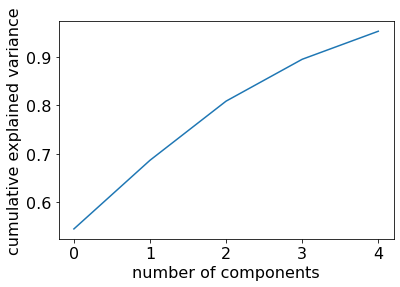

5
(1943, 36, 5)


In [51]:
scaler = StandardScaler()
num_instances, num_time_steps, num_features = X_train.shape

X_train_pca = np.reshape(X_train, newshape=(-1, num_features))
X_train_pca = scaler.fit_transform(X_train_pca)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

pca = PCA(n_components = 0.90)
X_train_pca = pca.fit_transform(X_train_pca) # this will fit and reduce dimensions
print(pca.n_components_) 

n_pcs= pca.n_components_
X_train_pca = np.reshape(X_train_pca, newshape=(num_instances, num_time_steps, pca.n_components_))
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

print(X_train_pca.shape)

In [50]:
num_instances, num_time_steps, num_features = X_validation.shape

X_validation_pca = np.reshape(X_validation, newshape=(-1, num_features))

X_validation_pca = scaler.transform(X_validation_pca)


X_validation_pca = pca.transform(X_validation_pca) # this will fit and reduce dimensions
print(pca.n_components_) 

X_validation_pca = np.reshape(X_validation_pca, newshape=(num_instances, num_time_steps, pca.n_components_))

print(X_validation_pca.shape)

5
(486, 36, 5)


In [33]:
"""
def build_parallel_cnn_lstm(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
     
    cnn1 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn1 = tfkl.MaxPooling1D()(cnn1)
    cnn1 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn1)
#     cnn1 = tfkl.GlobalAveragePooling1D()(cnn1)

    
    cnn2 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn2 = tfkl.MaxPooling1D()(cnn2)
    cnn2 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn2)
#     cnn2 = tfkl.GlobalAveragePooling1D()(cnn2)

    merged = tfk.layers.concatenate([cnn1, cnn2# cnn4
                                    ], axis=1)

#     reshape = tfkl.Reshape((cnn1.shape[1], classes))(merged)

    lstm = (tfkl.LSTM(1024, return_sequences=True))(merged)
    lstm = (tfkl.LSTM(1024))(lstm)
#     lstm = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(1024, activation='relu')(lstm)
#     bn = tfkl.BatchNormalization()(classifier)
    classifier = tfkl.Dense(1024, activation='relu')(classifier)
#     bn = tfkl.BatchNormalization()(classifier)
#     noise = tfkl.GaussianNoise(.1)(classifier)
    dropout = tfkl.Dropout(.4, seed=seed)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model
"""

In [34]:
"""
input_shape=[36,6]
X_train_reduced=X_train_pca

X_validation_reduced=X_validation_pca

model = build_parallel_cnn_lstm(input_shape, classes)
#model.summary()
#tfk.utils.plot_model(model)

# Train the model
history = model.fit(
    x = X_train_reduced,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(X_validation_reduced, y_validation),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history
"""

$$$$$$$$$$$$$$$$$$$$$$$$ we remove feature:  0 $$$$$$$$$$$$$$$$$
Epoch 1/200
61/61 [==============================] - 7s 84ms/step - loss: 1.7255 - accuracy: 0.4251 - val_loss: 1.3469 - val_accuracy: 0.5453
Epoch 2/200
29/61 [=============>................] - ETA: 2s - loss: 1.3318 - accuracy: 0.5345

KeyboardInterrupt: 

### Removing 1 feature


Here we are taking our best model so far, and try to remove one feature at time from the dataset, and then check if there's any improvement. We tried also this way to prevent our model to a big overfit. In fact the training accuracy reaches the 0.999, while the val_accuracy reaches at least 0.72. And so maybe with 5 features out of 6 could be implemented a model more general

We run a for cycle removing, one at  time, all the components, finding that the feature less important are feature 0, 2 and 5.

But, anyway, we did not find any relevant improvement

In [14]:
"""
def build_parallel_cnn_lstm(input_shape, classes):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    
    cnn1 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn1 = tfkl.MaxPooling1D()(cnn1)
    cnn1 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn1)
#     cnn1 = tfkl.GlobalAveragePooling1D()(cnn1)

    
    cnn2 = tfkl.Conv1D(512,3,padding='same',activation='relu')(input_layer)
#     cnn2 = tfkl.MaxPooling1D()(cnn2)
    cnn2 = tfkl.Conv1D(1024,3,padding='same',activation='relu')(cnn2)
#     cnn2 = tfkl.GlobalAveragePooling1D()(cnn2)

    merged = tfk.layers.concatenate([cnn1, cnn2# cnn4
                                    ], axis=1)

#     reshape = tfkl.Reshape((cnn1.shape[1], classes))(merged)

    lstm = (tfkl.LSTM(1024, return_sequences=True))(merged)
    lstm = (tfkl.LSTM(1024))(lstm)
#     lstm = tfkl.Dropout(.4, seed=seed)(lstm)

    # Classifier
    classifier = tfkl.Dense(1024, activation='relu')(lstm)
#     bn = tfkl.BatchNormalization()(classifier)
    classifier = tfkl.Dropout(.2, seed=seed)(classifier)
    classifier = tfkl.Dense(1024, activation='relu')(classifier)
#     bn = tfkl.BatchNormalization()(classifier)
#     noise = tfkl.GaussianNoise(.1)(classifier)
    dropout = tfkl.Dropout(.4, seed=seed)(classifier)

    output_layer = tfkl.Dense(classes, activation='softmax')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')

    # Return the model
    return model
"""



In [12]:
"""
for i in range(0,6):

    input_shape=[36,5]
    X_train_reduced=np.delete(X_train[:][:], i, axis=2)
    X_validation_reduced=np.delete(X_validation[:][:], i, axis=2)

    model = build_parallel_cnn_lstm(input_shape, classes)
    #model.summary()
    #tfk.utils.plot_model(model)

    print("$$$$$$$$$$$$$$$$$$$$$$$$ we remove feature: " , i, "$$$$$$$$$$$$$$$$$")
    # Train the model
    history = model.fit(
        x = X_train_reduced,
        y = y_train,
        batch_size = batch_size,
        epochs = epochs,
        validation_data=(X_validation_reduced, y_validation),
        callbacks = [
            tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=15, restore_best_weights=True),
            tfk.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-5)
        ]
    ).history
"""


$$$$$$$$$$$$$$$$$$$$$$$$ we remove feature:  0 $$$$$$$$$$$$$$$$$
Epoch 1/200
31/31 [==============================] - 7s 130ms/step - loss: 1.8866 - accuracy: 0.3752 - val_loss: 1.5363 - val_accuracy: 0.4650
Epoch 2/200
31/31 [==============================] - 3s 109ms/step - loss: 1.4562 - accuracy: 0.4915 - val_loss: 1.3113 - val_accuracy: 0.5453
Epoch 3/200
31/31 [==============================] - 3s 109ms/step - loss: 1.2641 - accuracy: 0.5677 - val_loss: 1.1865 - val_accuracy: 0.5885
Epoch 4/200
31/31 [==============================] - 3s 109ms/step - loss: 1.1935 - accuracy: 0.5903 - val_loss: 1.1404 - val_accuracy: 0.5823
Epoch 5/200
31/31 [==============================] - 3s 109ms/step - loss: 1.1019 - accuracy: 0.6166 - val_loss: 1.0706 - val_accuracy: 0.6111
Epoch 6/200
31/31 [==============================] - 3s 109ms/step - loss: 1.0097 - accuracy: 0.6485 - val_loss: 1.0731 - val_accuracy: 0.6296
Epoch 7/200
31/31 [==============================] - 3s 109ms/step - loss: 0.

In [13]:
"""
model.save('/kaggle/working/wofeature0') 

os.chdir(r'/kaggle/working')
!zip -r wofeature0.zip wofeature0
"""

2022-12-16 15:06:28.491282: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


  adding: wofeature0/ (stored 0%)
  adding: wofeature0/assets/ (stored 0%)
  adding: wofeature0/keras_metadata.pb (deflated 93%)
  adding: wofeature0/saved_model.pb (deflated 90%)
  adding: wofeature0/variables/ (stored 0%)
  adding: wofeature0/variables/variables.index (deflated 72%)
  adding: wofeature0/variables/variables.data-00000-of-00001 (deflated 7%)
